## 1. 라이브러리 불러오기

In [1]:
import cv2
import mediapipe as mp
import numpy as np

In [2]:
# mediapipe 기능 불러오기
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# 영상 파일 열기
cap = cv2.VideoCapture("../videos/attention.mp4")

# 총 프레임 개수 체크
total_frame_no = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [3]:
# Keypoints를 저장하기 위한 딕셔너리 초기화
keypoints_dict = {}

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    frame_num = 0
    last_valid_keypoints = None
    while cap.isOpened():
        ret, frame = cap.read()

        # 프레임이 제대로 읽혔는지 확인
        if not ret:
            break

        # 프레임의 너비와 높이 가져오기
        height, width, _ = frame.shape

        # BGR을 RGB로 변환
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # 성능 향상을 위해, 참조로 전달하기 위해 이미지를 변경할 수 없음을 표시합니다.
        image.flags.writeable = False

        # MediaPipe Pose 처리
        results = pose.process(image)

        # Keypoints 가져오기
        if results.pose_landmarks:
            keypoints = results.pose_landmarks.landmark
            keypoints_dict[frame_num] = [(int(keypoints[11].x * width), int(keypoints[11].y * height)),
                                         (int(keypoints[12].x * width), int(keypoints[12].y * height))]
            last_valid_keypoints = keypoints_dict[frame_num]
        else:
            keypoints_dict[frame_num] = last_valid_keypoints  # Keypoints가 감지되지 않으면 마지막 유효한 keypoints 사용

        frame_num += 1

# 누락된 Keypoints에 대한 후처리
# 처음 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no):
    if keypoints_dict[i] is not None:
        for j in range(i):
            keypoints_dict[j] = keypoints_dict[i]
        break

# 중간에서 Keypoints가 없는 경우
start_frame = None
for i in range(total_frame_no):
    if keypoints_dict[i] is None:
        if start_frame is None:
            start_frame = i - 1
    else:
        if start_frame is not None:
            # 누락된 Keypoints에 대한 선형 보간
            start = np.array(keypoints_dict[start_frame])
            end = np.array(keypoints_dict[i])
            for j in range(start_frame + 1, i):
                keypoints_dict[j] = tuple(int(start + (end - start) * (j - start_frame) / (i - start_frame)))
            start_frame = None

# 마지막 몇 프레임에 Keypoints가 없는 경우
for i in range(total_frame_no - 1, -1, -1):
    if keypoints_dict[i] is not None:
        for j in range(i + 1, total_frame_no):
            keypoints_dict[j] = keypoints_dict[i]
        break

cap.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
# 1. x_center를 구하기 위한 함수
x_centers = []

for idx in range(len(keypoints_dict)):
    x_centers.append((keypoints_dict[idx][0][0] + keypoints_dict[idx][1][0]) // 2)

# =======================================================================================
# 2. 이동평균을 구하는 함수
def calculate_moving_average(numbers, window_size):
    moving_averages = []
    for i in range(len(numbers)):
        if i < window_size - 1:
            # If window size not reached, calculate average with available numbers
            window_sum = sum(numbers[:i+1])
            moving_averages.append(int(window_sum / (i+1)))
        else:
            window_sum = sum(numbers[i-window_size+1:i+1])
            moving_averages.append(int(window_sum / window_size))
    return moving_averages

# =======================================================================================
# 3. 30프레임 이동평균을 담은 x_centers
x_centers_movavg = calculate_moving_average(x_centers, 15)

# =======================================================================================
# 4. 프레임의 갯수 체크
print(len(x_centers))
print(len(x_centers_movavg))

3181
3181


In [5]:
# 이동평균을 구했을 때 발생하는 x_center의 최대 오차
max_diff = 0
for i in range(len(x_centers)):
    diff = abs(x_centers[i] - x_centers_movavg[i])
    if diff > max_diff:
        max_diff = diff
    
print(max_diff)

72


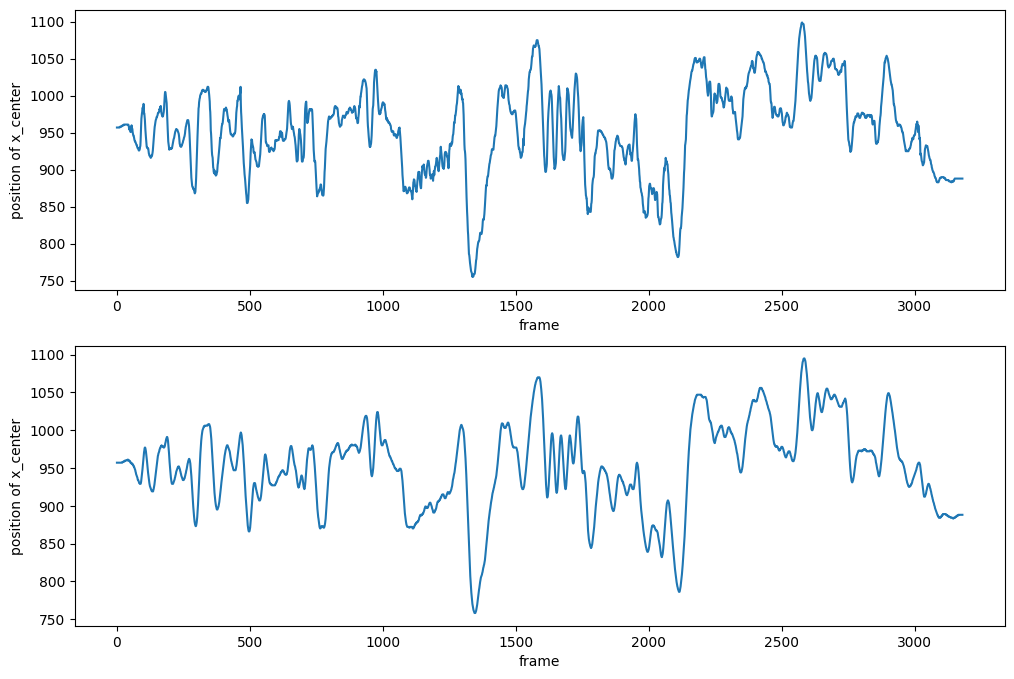

In [11]:
# 원본 x_centers와 이동평균을 구해 smoothing한 x_centers의 시각적 비교
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))


plt.subplot(2,1,1)
plt.plot(x_centers)
plt.xlabel("frame")
plt.ylabel("position of x_center")

plt.subplot(2,1,2)
plt.plot(x_centers_movavg)
plt.xlabel("frame")
plt.ylabel("position of x_center")

plt.show()

In [12]:
cap = cv2.VideoCapture("../videos/attention.mp4")

# 키포인트의 x 좌표값이 담긴 배열
x_centers = np.array(x_centers_movavg)

fourcc = cv2.VideoWriter_fourcc(*"avc1")
out = cv2.VideoWriter("../temp/attetion.mp4", fourcc, 30.0, (int(1080*(9/16)), 1080))

frame_no = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        # frame.shape = (height, width, channel)
        H, W = frame.shape[:2]
        
        # 중심점 x 좌표를 가져옵니다.
        x_center = x_centers[frame_no]
        
        # 크롭할 영역의 좌상단과 우하단 좌표를 계산합니다.
        start_x = max(0, int(x_center - (1080*(9/16))//2))
        end_x = min(W, int(x_center + (1080*(9/16))//2))
        start_y = 0
        end_y = H

        # 크롭한 영역을 가져옵니다.
        cropped_frame = frame[start_y:end_y, start_x:end_x]
        
        # 크롭한 영역의 크기를 조정합니다.
        resized_frame = cv2.resize(cropped_frame, (int(1080*(9/16)), 1080))
        
        # 결과 영상에 프레임을 씁니다.
        out.write(resized_frame)

        frame_no += 1
    else:
        break

cap.release()
out.release()